# Tuning MCTS params to support policy training

We are using the Upper Confidence Bound for MCTS

$$
U(s, a) = Q(s, a) + c_{puct} P(s, a) \frac{\sqrt{\sum_b N(s, b)}}{1 + N(s, a)}
$$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from tqdm import tqdm

from aegomoku.gomoku_board import GomokuBoard
from aegomoku.gomoku_game import ConstantBoardInitializer, GomokuGame as Game
from aegomoku.interfaces import MctsParams, PolicyAdviser, PolicyParams
from aegomoku.mcts import MCTS
from aegomoku.gomoku_players import PolicyAdvisedGraphSearchPlayer
from aegomoku.policies.topological_value import TopologicalValuePolicy
from aegomoku.utils import analyse_board

2022-09-10 12:16:33.720741: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-10 12:16:33.720763: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
BOARD_SIZE=19


---
### The initial board

In [82]:
# Yixin says: This is a 100% win for white - I guess we're not quite there, yet...;-(
# stones = "C11F9E9G8F7G7G9H8"
stones = "C11F9E9G8F7G7G9H8I8H7I6I9F6H6H9I5J4"
# stones = "H8G8"
stones = [256, 276, 238, 240, 219, 237, 184, 199]

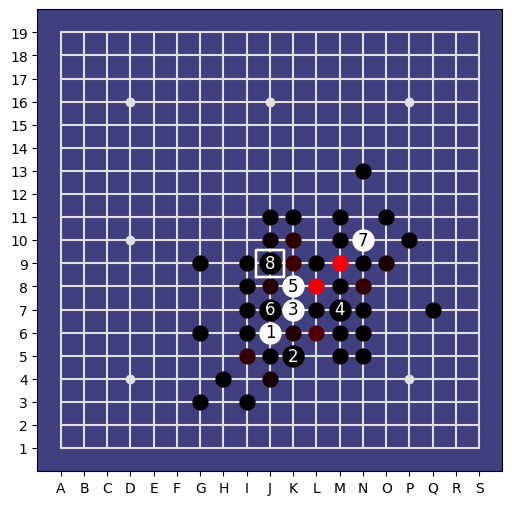

In [83]:
policy = TopologicalValuePolicy(kappa_s=6, kappa_d=5)

analyse_board(BOARD_SIZE, stones, policy, disp_width=6, policy_cutoff=.01)

In [84]:
the_game = Game(BOARD_SIZE, initializer=ConstantBoardInitializer(''))

In [85]:
mcts_params = MctsParams(cpuct=1.0, num_simulations=400, temperature=1.0)
policy_params = PolicyParams(model_file_name=None, advice_cutoff=.01)
advisor = PolicyAdviser(model=policy, params = policy_params)
player = PolicyAdvisedGraphSearchPlayer("Tester", the_game, mcts_params, adviser=advisor)

In [86]:
board = GomokuBoard(BOARD_SIZE, stones)

---

# Essential Parameter: MCTS score read-out temperature
A readout temperature between 4 and 6 will produce a reasonable input for future advice!

Policy with decreasing readout temperatur


/home/wgiersche/.local/share/virtualenvs/DeepGomoku-yQC4gx5q/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
100%|██████████| 6/6 [00:00<00:00, 13.80it/s]


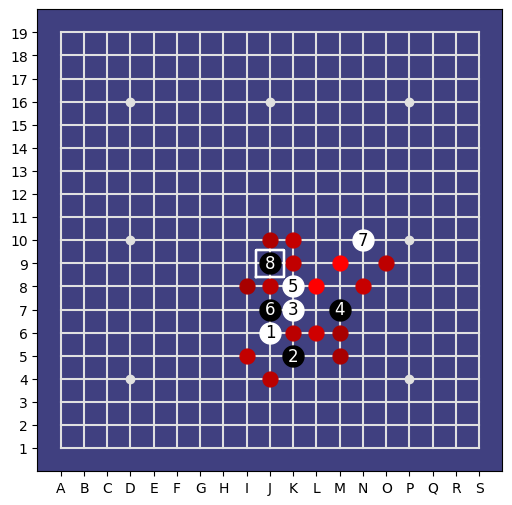

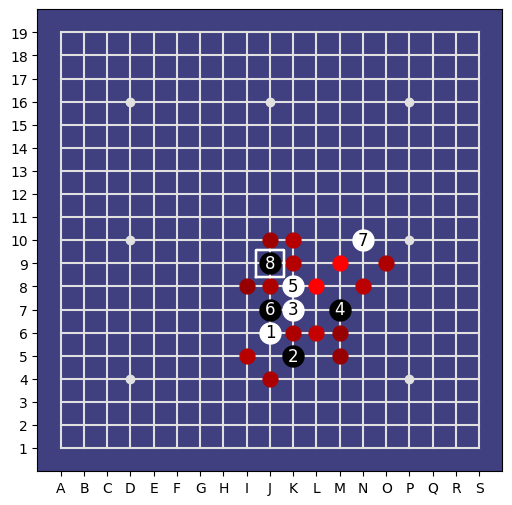

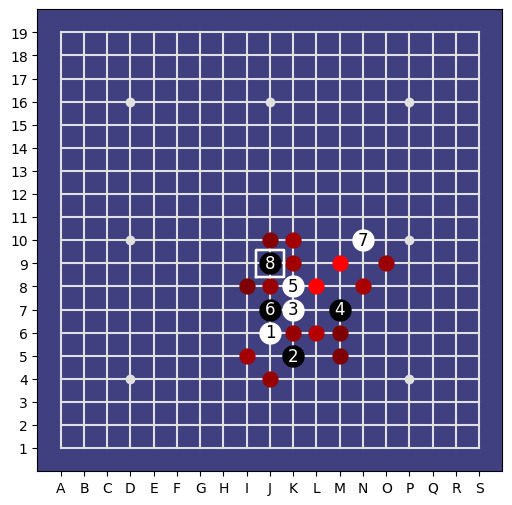

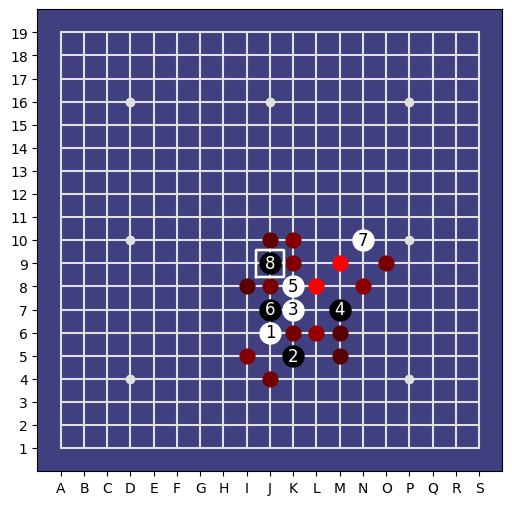

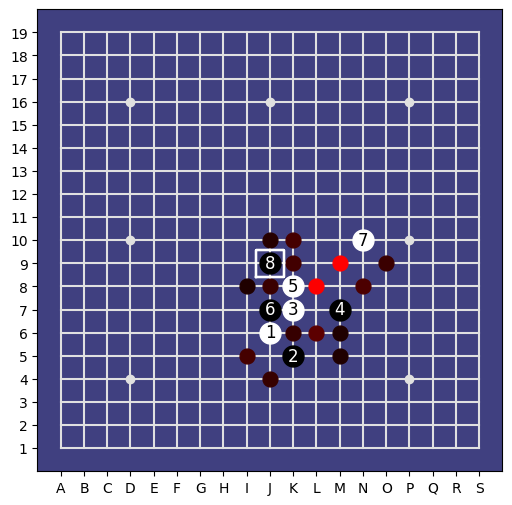

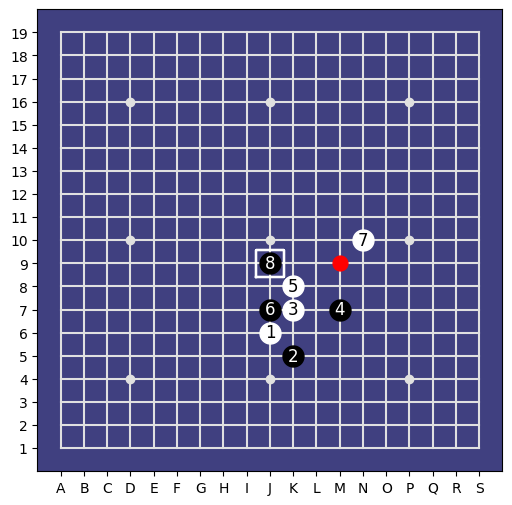

In [87]:
print("Policy with decreasing readout temperatur")
player.refresh()
player.mcts.get_action_prob(board)
for t in tqdm(range(10, -1, -2)):
    probs, v = player.evaluate(board, t)
    analyse_board(BOARD_SIZE, stones, probs, disp_width=6, policy_cutoff=.01)

In [88]:
probs, _ = player.evaluate(board, 6)
print((np.reshape(probs, (BOARD_SIZE, BOARD_SIZE)) * 99 / np.max(probs)).astype(int))

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 51 62  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 61  0 99  0 59  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 47 59  0 98  0 64  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 57 69 47  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 62  0  0  0 47  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 57  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0